In [1]:
import cpr_gym
import itertools
import git
import gym
import numpy as np
import os
import pandas as pd
import pathlib
import seaborn as sns
import time
import warnings
from pandarallel import pandarallel
from stable_baselines3 import PPO

pandarallel.initialize(progress_bar=True)

print("cpr_lib_version: " + cpr_gym.engine.cpr_lib_version)

repo = git.Repo(".", search_parent_directories=True)
repo.working_tree_dir
os.chdir(repo.working_tree_dir)

INFO: Pandarallel will run on 6 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.
cpr_lib_version: local-v0.4-106-ga0e66e0


# Run simulations with trained models

In [2]:
def models():
    for m in pathlib.Path("data/models").glob("*-sb3-ppo-*.zip"):
        x = m.stem.split("-sb3-ppo-")
        y = x[1].split("-")
        protocol = y[0]
        if protocol == "nakamoto":
            yield dict(
                model=x[0],
                protocol=y[0],
                k=1,
                reward="btc",
                subblock_selection="n/a",
                gamma=int(y[1].removeprefix("gamma")) / 100,
                path=m,
            )
        elif protocol == "tailstorm" or protocol == "tailstormll":
            yield dict(
                model=x[0],
                protocol=y[0],
                k=int(y[1]),
                reward=y[2],
                subblock_selection=y[3],
                gamma=int(y[4].removeprefix("gamma")) / 100,
                path=m,
            )
        else:
            raise Exception(f"unsupported protocol: {protocol}")


models = pd.DataFrame(models())
models = pd.concat(
    [
        models.assign(kind="trained"),
        models.query(
            'protocol == "tailstorm" and subblock_selection == "heuristic"'
        ).assign(kind="reused", subblock_selection="optimal"),
        models.query('protocol == "tailstorm" and reward == "constant"').assign(
            kind="reused", reward="discount"
        ),
    ],
    ignore_index=True,
)
models

,model,protocol,k,reward,subblock_selection,gamma,path,kind
0,wandb-352,nakamoto,1,btc,n/a,0.5,data/models/wandb-352-sb3-ppo-nakamoto-gamma50...,trained
1,wandb-361,nakamoto,1,btc,n/a,0.5,data/models/wandb-361-sb3-ppo-nakamoto-gamma50...,trained
2,wandb-337,tailstorm,8,constant,heuristic,0.5,data/models/wandb-337-sb3-ppo-tailstorm-8-cons...,trained
3,wandb-337,tailstorm,8,constant,optimal,0.5,data/models/wandb-337-sb3-ppo-tailstorm-8-cons...,reused
4,wandb-337,tailstorm,8,discount,heuristic,0.5,data/models/wandb-337-sb3-ppo-tailstorm-8-cons...,reused


In [3]:
protocols = dict(
    nakamoto=(cpr_gym.protocols.nakamoto, []),
    tailstorm=(cpr_gym.protocols.tailstorm, ["k", "reward", "subblock_selection"]),
    tailstormll=(cpr_gym.protocols.tailstormll, ["k", "reward", "subblock_selection"]),
)
episode_len = 2048
n_episodes = 25
alpha = np.arange(0.1, 0.501, 0.025)


def episodes():
    for i in range(0, n_episodes):
        for a in alpha:
            yield models.assign(episode=i, alpha=a)


episodes = pd.concat(episodes(), ignore_index=True)


def sparse_env(x):
    proto, proto_args = protocols[x.protocol]
    proto_args = {k: x[k] for k in proto_args}
    env = gym.make(
        "cpr_gym:core-v0",
        proto=proto(**proto_args),
        gamma=x.gamma,
        alpha=x.alpha,
        max_time=episode_len,
        max_steps=episode_len * 10000,
    )
    return env


loaded = {}


def load(path):
    if path in loaded.keys():
        return loaded[path]
    else:
        m = PPO.load(path)
        loaded[path] = m
        return m


def observe_episode(info):
    return pd.Series(
        {
            k: info[k]
            for k in [
                "episode_reward_attacker",
                "episode_chain_time",
                "episode_progress",
            ]
        }
    )


def measure(x):
    env = sparse_env(x)
    model = load(x.path)
    obs = env.reset()
    done = False
    while not done:
        extobs = np.append(obs, [x.alpha])
        action, _ = model.predict(extobs, deterministic=True)
        obs, _reward, done, info = env.step(action)
    return observe_episode(info)


# run simulations
# results = episodes.apply(
results = episodes.parallel_apply(
    measure,
    axis=1,
)
rl_episodes = pd.concat([episodes, results], axis=1)
rl_episodes

,model,protocol,k,reward,subblock_selection,gamma,path,kind,episode,alpha,episode_reward_attacker,episode_chain_time,episode_progress
0,wandb-352,nakamoto,1,btc,n/a,0.5,data/models/wandb-352-sb3-ppo-nakamoto-gamma50...,trained,0,0.1,206.000,2048.077233,2042.0
1,wandb-361,nakamoto,1,btc,n/a,0.5,data/models/wandb-361-sb3-ppo-nakamoto-gamma50...,trained,0,0.1,218.000,2048.605388,2107.0
2,wandb-337,tailstorm,8,constant,heuristic,0.5,data/models/wandb-337-sb3-ppo-tailstorm-8-cons...,trained,0,0.1,200.000,2044.870577,2008.0
3,wandb-337,tailstorm,8,constant,optimal,0.5,data/models/wandb-337-sb3-ppo-tailstorm-8-cons...,reused,0,0.1,183.000,2047.506397,2024.0
4,wandb-337,tailstorm,8,discount,heuristic,0.5,data/models/wandb-337-sb3-ppo-tailstorm-8-cons...,reused,0,0.1,172.625,2044.508040,2008.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2120,wandb-352,nakamoto,1,btc,n/a,0.5,data/models/wandb-352-sb3-ppo-nakamoto-gamma50...,trained,24,0.5,942.000,2046.284863,1092.0
2121,wandb-361,nakamoto,1,btc,n/a,0.5,data/models/wandb-361-sb3-ppo-nakamoto-gamma50...,trained,24,0.5,1044.000,2047.921330,1075.0
2122,wandb-337,tailstorm,8,constant,heuristic,0.5,data/models/wandb-337-sb3-ppo-tailstorm-8-cons...,trained,24,0.5,1050.000,2033.539439,1104.0
2123,wandb-337,tailstorm,8,constant,optimal,0.5,data/models/wandb-337-sb3-ppo-tailstorm-8-cons...,reused,24,0.5,605.000,2044.138528,1080.0


## Patrik-style rewards

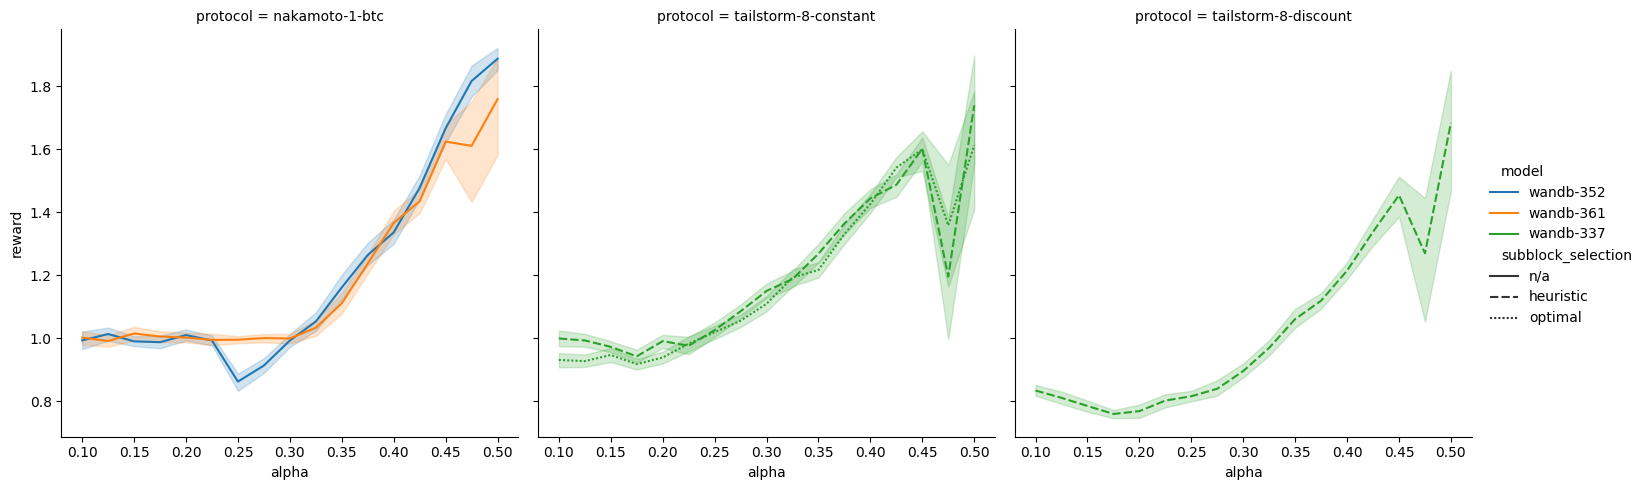

In [4]:
d = rl_episodes
sns.relplot(
    data=d.assign(
        protocol=d.protocol + "-" + d.k.map(str) + "-" + d.reward,
        reward=d.episode_reward_attacker / d.episode_progress / d.alpha,
    ),
    kind="line",
    x="alpha",
    y="reward",
    hue="model",
    style="subblock_selection",
    col="protocol",
)

## Ben-style rewards

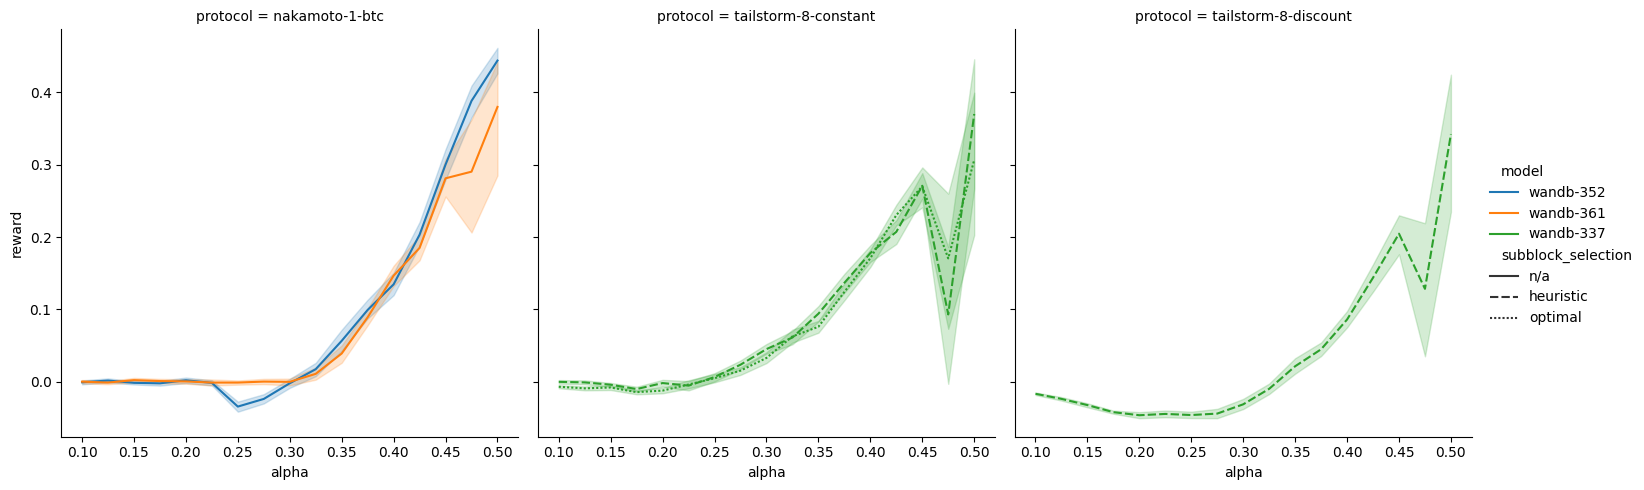

In [5]:
d = rl_episodes
sns.relplot(
    data=d.assign(
        protocol=d.protocol + "-" + d.k.map(str) + "-" + d.reward,
        reward=d.episode_reward_attacker / d.episode_progress - d.alpha,
    ),
    kind="line",
    x="alpha",
    y="reward",
    hue="model",
    style="subblock_selection",
    col="protocol",
)

# Simulate hard-coded policies

In [6]:
scenarios = models[
    ["protocol", "k", "reward", "subblock_selection", "gamma"]
].drop_duplicates()


def episodes():
    for _idx, x in scenarios.iterrows():
        x = x.copy()
        x["alpha"] = 0.0
        env = sparse_env(x)
        for p in env.policies():
            for i in range(0, n_episodes):
                for a in alpha:
                    x = x.copy()
                    x["policy"] = p
                    x["alpha"] = a
                    x["episode"] = i
                    yield x


episodes = pd.DataFrame(episodes()).reset_index(drop=True)


def measure(x):
    env = sparse_env(x)
    obs = env.reset()
    done = False
    while not done:
        action = env.policy(obs, x.policy)
        obs, reward, done, info = env.step(action)
    return observe_episode(info)


# run simulations
results = episodes.parallel_apply(
    measure,
    axis=1,
)
hc_episodes = pd.concat([episodes, results], axis=1)
hc_episodes

,protocol,k,reward,subblock_selection,gamma,alpha,policy,episode,episode_reward_attacker,episode_chain_time,episode_progress
0,nakamoto,1,btc,n/a,0.5,0.100,sapirshtein-2016-sm1,0,122.0,2048.346802,1896.0
1,nakamoto,1,btc,n/a,0.5,0.125,sapirshtein-2016-sm1,0,187.0,2048.563680,1847.0
2,nakamoto,1,btc,n/a,0.5,0.150,sapirshtein-2016-sm1,0,213.0,2045.582431,1768.0
3,nakamoto,1,btc,n/a,0.5,0.175,sapirshtein-2016-sm1,0,281.0,2047.822126,1781.0
4,nakamoto,1,btc,n/a,0.5,0.200,sapirshtein-2016-sm1,0,337.0,2047.588726,1737.0
...,...,...,...,...,...,...,...,...,...,...,...
6795,tailstorm,8,discount,heuristic,0.5,0.400,honest,24,786.0,2042.956560,1992.0
6796,tailstorm,8,discount,heuristic,0.5,0.425,honest,24,867.0,2046.902984,2088.0
6797,tailstorm,8,discount,heuristic,0.5,0.450,honest,24,930.0,2045.986656,2072.0
6798,tailstorm,8,discount,heuristic,0.5,0.475,honest,24,1021.0,2046.669950,2064.0


# Determine best hard-coded policies

In [7]:
key = ["protocol", "k", "reward", "subblock_selection", "gamma", "alpha"]
d = hc_episodes
d = d.assign(episode_reward=d.episode_reward_attacker / d.episode_progress)
mean_reward = d.groupby(key + ["policy"]).episode_reward.mean().reset_index()
opt_idx = mean_reward.reset_index().groupby(key).episode_reward.idxmax()
opt_policies = mean_reward.iloc[opt_idx].set_index(key)
opt_policies

policy  \
protocol  k reward   subblock_selection gamma alpha                     
nakamoto  1 btc      n/a                0.5   0.100            honest   
                                              0.125            honest   
                                              0.150            honest   
                                              0.175            honest   
                                              0.200            honest   
...                                                               ...   
tailstorm 8 discount heuristic          0.5   0.400  override-catchup   
                                              0.425  override-catchup   
                                              0.450  override-catchup   
                                              0.475  override-catchup   
                                              0.500  override-catchup   

                                                     episode_reward  
protocol  k reward   subblock_selection gamma alpha                  
nakamoto  1 btc      n/a                0.5   0.100        0.100289  
                                              0.125        0.124599  
                                              0.150        0.151197  
                                              0.175        0.175061  
                                              0.200        0.202572  
...                                                             ...  
tailstorm 8 discount heuristic          0.5   0.400        0.445479  
                                              0.425        0.482281  
                                              0.450        0.571623  
                                              0.475        0.670431  
                                              0.500        0.796839  

[68 rows x 2 columns]

In [8]:
mhc_episodes = (
    hc_episodes.join(opt_policies.policy, on=key, rsuffix="_opt")
    .query("policy == policy_opt")
    .reset_index(drop=True)
    .drop(columns=["policy_opt"])
    .assign(model="max-hard-coded", kind="hard-coded")
)
episodes = pd.concat([rl_episodes, mhc_episodes], axis=0, ignore_index=True)
episodes

,model,protocol,k,reward,subblock_selection,gamma,path,kind,episode,alpha,episode_reward_attacker,episode_chain_time,episode_progress,policy
0,wandb-352,nakamoto,1,btc,n/a,0.5,data/models/wandb-352-sb3-ppo-nakamoto-gamma50...,trained,0,0.100,206.000,2048.077233,2042.0,NaN
1,wandb-361,nakamoto,1,btc,n/a,0.5,data/models/wandb-361-sb3-ppo-nakamoto-gamma50...,trained,0,0.100,218.000,2048.605388,2107.0,NaN
2,wandb-337,tailstorm,8,constant,heuristic,0.5,data/models/wandb-337-sb3-ppo-tailstorm-8-cons...,trained,0,0.100,200.000,2044.870577,2008.0,NaN
3,wandb-337,tailstorm,8,constant,optimal,0.5,data/models/wandb-337-sb3-ppo-tailstorm-8-cons...,reused,0,0.100,183.000,2047.506397,2024.0,NaN
4,wandb-337,tailstorm,8,discount,heuristic,0.5,data/models/wandb-337-sb3-ppo-tailstorm-8-cons...,reused,0,0.100,172.625,2044.508040,2008.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3820,max-hard-coded,tailstorm,8,discount,heuristic,0.5,NaN,hard-coded,24,0.275,559.000,2044.032628,2048.0,honest
3821,max-hard-coded,tailstorm,8,discount,heuristic,0.5,NaN,hard-coded,24,0.300,606.000,2046.406444,2024.0,honest
3822,max-hard-coded,tailstorm,8,discount,heuristic,0.5,NaN,hard-coded,24,0.325,669.000,2048.535880,2112.0,honest
3823,max-hard-coded,tailstorm,8,discount,heuristic,0.5,NaN,hard-coded,24,0.350,740.000,2048.090259,2048.0,honest


# Compare RL against best hard-coded

## Reward per progress (in DAA equilibrium)

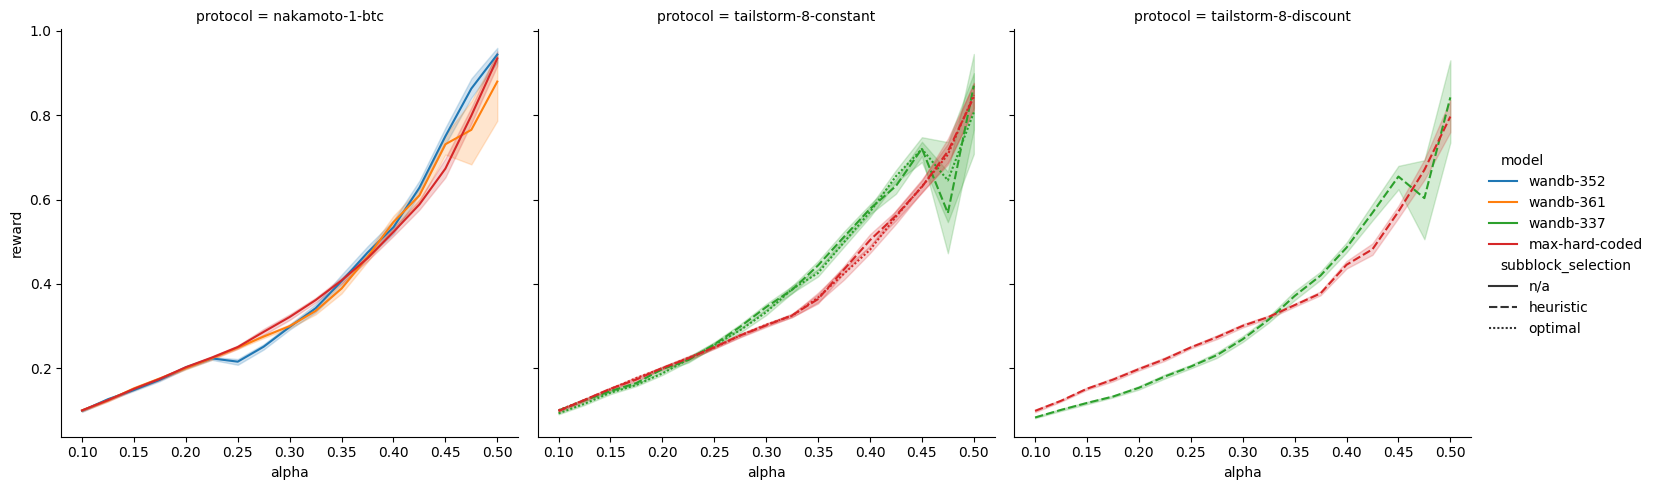

In [9]:
d = episodes
sns.relplot(
    data=d.assign(
        protocol=d.protocol + "-" + d.k.map(str) + "-" + d.reward,
        reward=d.episode_reward_attacker / d.episode_progress,
    ),
    kind="line",
    x="alpha",
    y="reward",
    hue="model",
    style="subblock_selection",
    col="protocol",
)

## Reward, Patrik-style

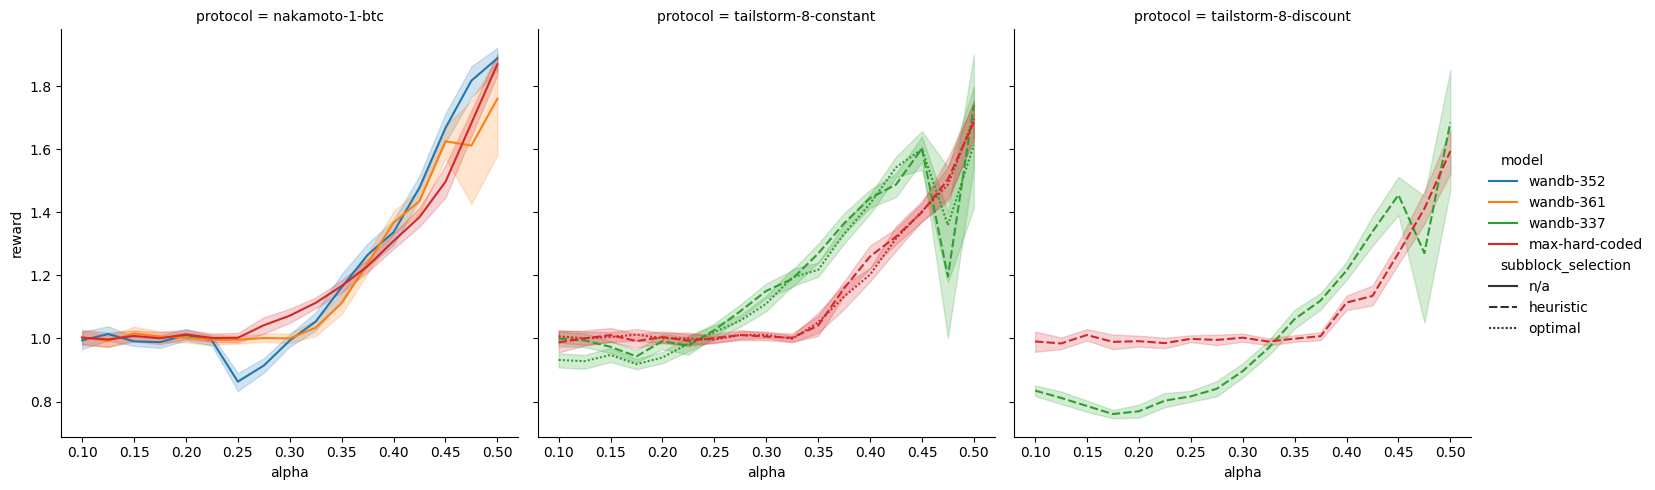

In [10]:
d = episodes
sns.relplot(
    data=d.assign(
        protocol=d.protocol + "-" + d.k.map(str) + "-" + d.reward,
        reward=d.episode_reward_attacker / d.episode_progress / d.alpha,
    ),
    kind="line",
    x="alpha",
    y="reward",
    hue="model",
    style="subblock_selection",
    col="protocol",
)

## Reward, Ben-style

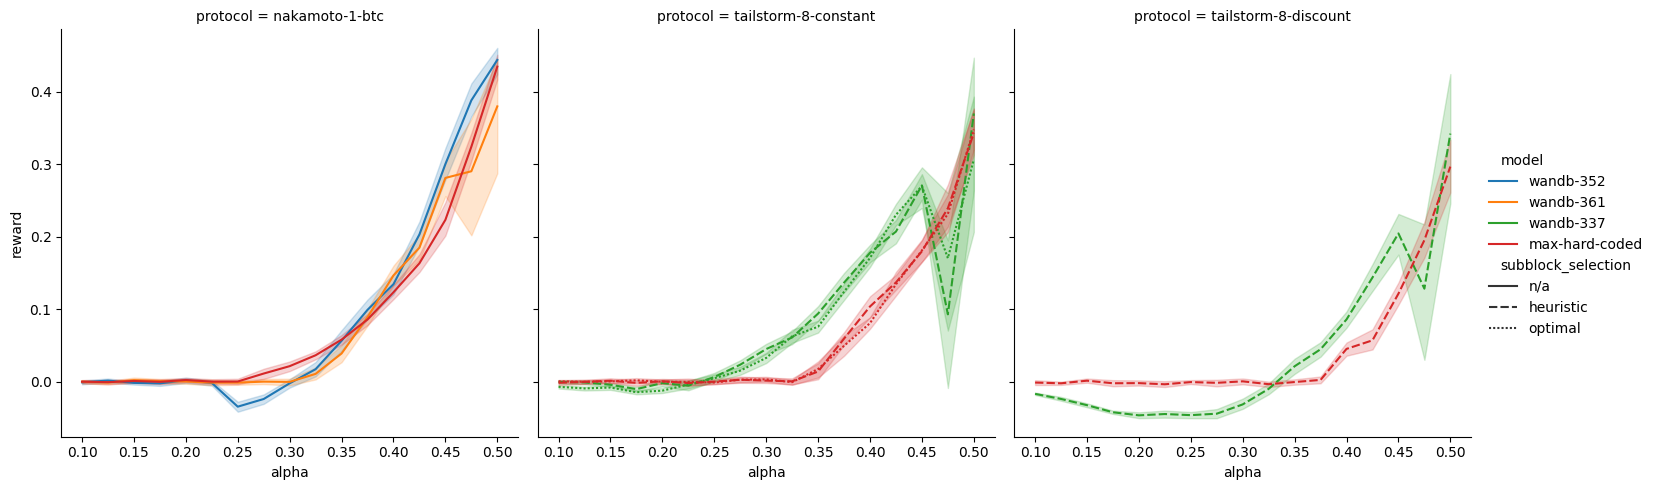

In [11]:
d = episodes
sns.relplot(
    data=d.assign(
        protocol=d.protocol + "-" + d.k.map(str) + "-" + d.reward,
        reward=d.episode_reward_attacker / d.episode_progress - d.alpha,
    ),
    kind="line",
    x="alpha",
    y="reward",
    hue="model",
    style="subblock_selection",
    col="protocol",
)

## Orphans

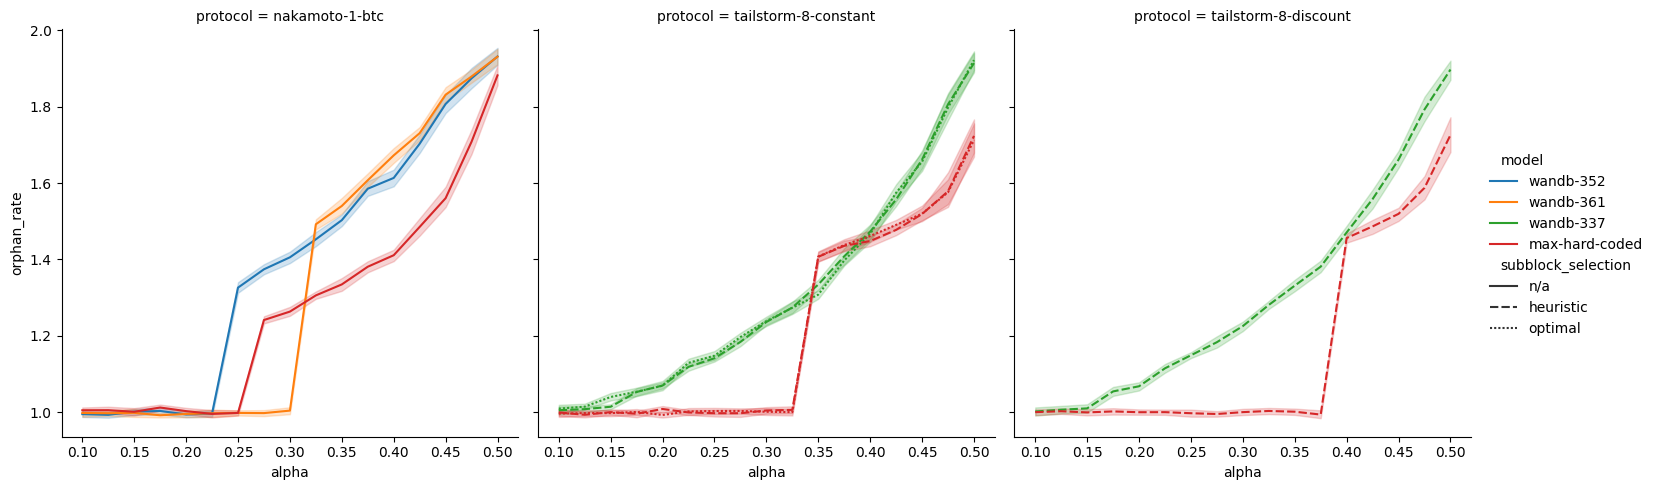

In [12]:
d = episodes
sns.relplot(
    data=d.assign(
        protocol=d.protocol + "-" + d.k.map(str) + "-" + d.reward,
        orphan_rate=d.episode_chain_time / d.episode_progress,
    ),
    kind="line",
    x="alpha",
    y="orphan_rate",
    hue="model",
    style="subblock_selection",
    col="protocol",
)

# Find best known strategies; compare protocols

In [13]:
key = ["protocol", "k", "reward", "subblock_selection", "gamma", "alpha"]
d = episodes
d = d.assign(episode_reward=d.episode_reward_attacker / d.episode_progress)
mean_reward = d.groupby(key + ["model"]).episode_reward.mean().reset_index()
opt_idx = mean_reward.reset_index().groupby(key).episode_reward.idxmax()
opt_models = mean_reward.iloc[opt_idx].set_index(key)
opt_models

model  \
protocol  k reward   subblock_selection gamma alpha                   
nakamoto  1 btc      n/a                0.5   0.100  max-hard-coded   
                                              0.125       wandb-352   
                                              0.150       wandb-361   
                                              0.175       wandb-361   
                                              0.200  max-hard-coded   
...                                                             ...   
tailstorm 8 discount heuristic          0.5   0.400       wandb-337   
                                              0.425       wandb-337   
                                              0.450       wandb-337   
                                              0.475  max-hard-coded   
                                              0.500       wandb-337   

                                                     episode_reward  
protocol  k reward   subblock_selection gamma alpha                  
nakamoto  1 btc      n/a                0.5   0.100        0.100289  
                                              0.125        0.126764  
                                              0.150        0.152370  
                                              0.175        0.176063  
                                              0.200        0.202572  
...                                                             ...  
tailstorm 8 discount heuristic          0.5   0.400        0.486098  
                                              0.425        0.568896  
                                              0.450        0.654709  
                                              0.475        0.670431  
                                              0.500        0.842383  

[68 rows x 2 columns]

In [14]:
mm_episodes = (
    episodes.join(opt_models.model, on=key, rsuffix="_opt")
    .query("model == model_opt")
    .reset_index(drop=True)
    .drop(columns=["policy", "model_opt"])
)
mm_episodes

,model,protocol,k,reward,subblock_selection,gamma,path,kind,episode,alpha,episode_reward_attacker,episode_chain_time,episode_progress
0,wandb-337,tailstorm,8,constant,heuristic,0.5,data/models/wandb-337-sb3-ppo-tailstorm-8-cons...,trained,0,0.100,200.0,2044.870577,2008.0
1,wandb-352,nakamoto,1,btc,n/a,0.5,data/models/wandb-352-sb3-ppo-nakamoto-gamma50...,trained,0,0.125,261.0,2048.025965,2044.0
2,wandb-361,nakamoto,1,btc,n/a,0.5,data/models/wandb-361-sb3-ppo-nakamoto-gamma50...,trained,0,0.150,310.0,2048.044270,1983.0
3,wandb-361,nakamoto,1,btc,n/a,0.5,data/models/wandb-361-sb3-ppo-nakamoto-gamma50...,trained,0,0.175,351.0,2049.737954,2094.0
4,wandb-337,tailstorm,8,constant,heuristic,0.5,data/models/wandb-337-sb3-ppo-tailstorm-8-cons...,trained,0,0.250,489.0,2045.015797,1784.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1695,max-hard-coded,tailstorm,8,discount,heuristic,0.5,NaN,hard-coded,24,0.225,444.0,2044.494239,2024.0
1696,max-hard-coded,tailstorm,8,discount,heuristic,0.5,NaN,hard-coded,24,0.250,502.0,2042.916703,2072.0
1697,max-hard-coded,tailstorm,8,discount,heuristic,0.5,NaN,hard-coded,24,0.275,559.0,2044.032628,2048.0
1698,max-hard-coded,tailstorm,8,discount,heuristic,0.5,NaN,hard-coded,24,0.300,606.0,2046.406444,2024.0


## Reward per progress (in DAA equilibrium)

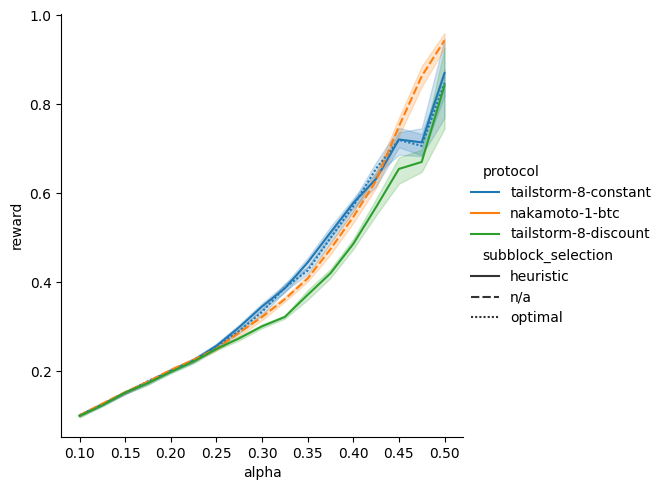

In [15]:
d = mm_episodes
sns.relplot(
    data=d.assign(
        protocol=d.protocol + "-" + d.k.map(str) + "-" + d.reward,
        reward=d.episode_reward_attacker / d.episode_progress,
    ),
    kind="line",
    x="alpha",
    y="reward",
    style="subblock_selection",
    hue="protocol",
)

## Reward, Patrik-style

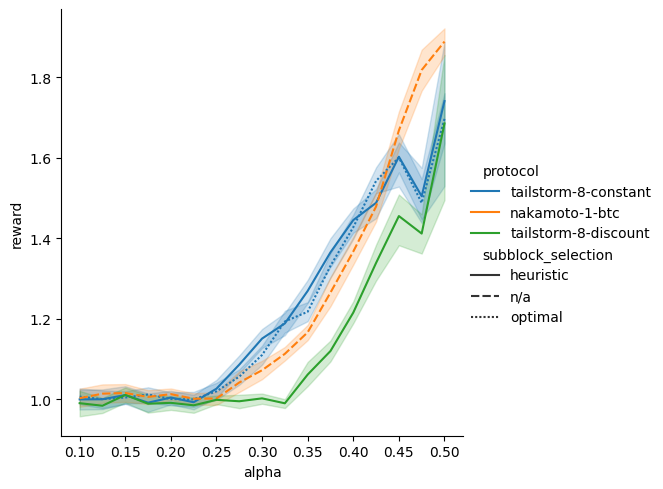

In [16]:
d = mm_episodes
sns.relplot(
    data=d.assign(
        protocol=d.protocol + "-" + d.k.map(str) + "-" + d.reward,
        reward=d.episode_reward_attacker / d.episode_progress / d.alpha,
    ),
    kind="line",
    x="alpha",
    y="reward",
    style="subblock_selection",
    hue="protocol",
)

## Reward, Ben-style

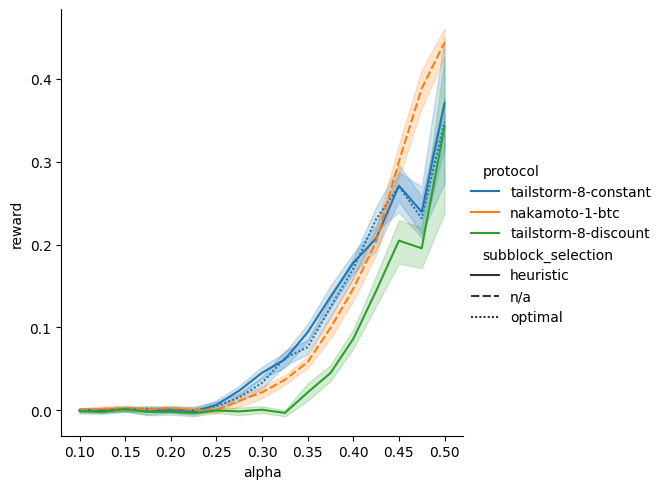

In [17]:
d = mm_episodes
sns.relplot(
    data=d.assign(
        protocol=d.protocol + "-" + d.k.map(str) + "-" + d.reward,
        reward=d.episode_reward_attacker / d.episode_progress - d.alpha,
    ),
    kind="line",
    x="alpha",
    y="reward",
    style="subblock_selection",
    hue="protocol",
)

## Orphans

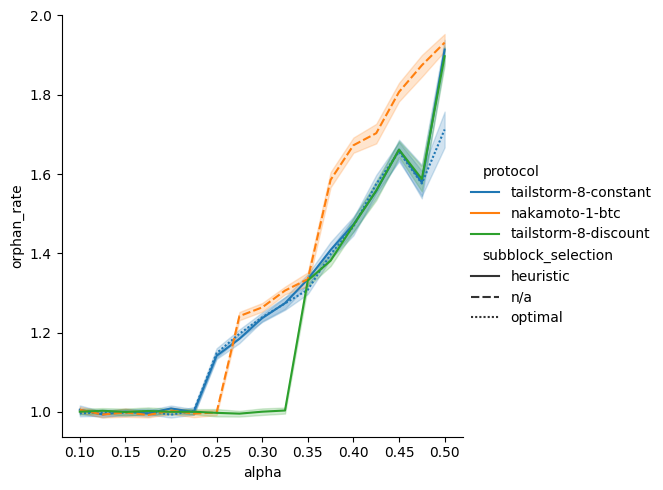

In [18]:
d = mm_episodes
sns.relplot(
    data=d.assign(
        protocol=d.protocol + "-" + d.k.map(str) + "-" + d.reward,
        orphan_rate=d.episode_chain_time / d.episode_progress,
    ),
    kind="line",
    x="alpha",
    y="orphan_rate",
    style="subblock_selection",
    hue="protocol",
)

## Compress x-axis into single value

The resulting numbers are hard to interpret. Certainly, smaller implies less selfish-mining suspectibility, I'd say.

In [19]:
key = ["protocol", "k", "reward", "subblock_selection"]
d = mm_episodes
d = (
    d.assign(
        raw=d.episode_reward_attacker / d.episode_progress,
        ben=d.episode_reward_attacker / d.episode_progress - d.alpha,
        patrik=d.episode_reward_attacker / d.episode_progress / d.alpha,
    )[key + ["raw", "ben", "patrik"]]
    .groupby(key)
    .mean()
)
d

raw       ben    patrik
protocol  k reward   subblock_selection                              
nakamoto  1 btc      n/a                 0.401117  0.101117  1.231272
tailstorm 8 constant heuristic           0.396057  0.096057  1.227334
                     optimal             0.392436  0.092436  1.218011
            discount heuristic           0.360395  0.060395  1.130849